# Generative models

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

## Text generation

We will use the IMDB movie review dataset first introduced [here](http://www.aclweb.org/anthology/P11-1015) and used for sentiment analysis.

In [2]:
tf.keras.utils.get_file('aclImdb_v1.tar.gz',
                        'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

84140032/84125825 [==============================] - 3s 0us/step


'./datasets/aclImdb_v1.tar.gz'

In [3]:
# Create a dataset object to feed the data to our model.
dataset = keras.utils.text_dataset_from_directory(directory="./datasets/aclImdb",
                                                  label_mode=None,
                                                  batch_size=256)

# Strip the line break HTML tag <br />
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 100006 files belonging to 1 classes.


In [4]:
# Vectorization
sequence_length = 40
vocab_size = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize='lower_and_strip_punctuation',
)
text_vectorization.adapt(dataset)
text_vectorization.vocabulary_size()

10000

In [5]:
# Vectorization dictionary
tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

In [6]:
# The input, output pair of our text generating model is the same as a 
# stand-along decoder.

def prepare_lm_dataset(text_batch):
    vectorized_sequences = text_vectorization(text_batch)
    # The inputs are partial sentences
    x = vectorized_sequences[:, :-1]
    # The outputs are the input sentences offset by 1.
    y = vectorized_sequences[:, 1:]
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

In [7]:
for x in lm_dataset:
    print(x)
    break

(<tf.Tensor: shape=(256, 39), dtype=int64, numpy=
array([[ 131,   10,  234, ...,   10,  130, 1283],
       [   9,   13,   96, ...,  171, 1294,   14],
       [  10,   13,   63, ...,    1,  113,    2],
       ...,
       [  10,  554,  193, ...,  128,   15,   41],
       [ 144,    4,  327, ...,    1,   13,   49],
       [  11,    7,    4, ...,   10, 3500,  758]])>, <tf.Tensor: shape=(256, 39), dtype=int64, numpy=
array([[  10,  234,    4, ...,  130, 1283,    6],
       [  13,   96,    8, ..., 1294,   14,   10],
       [  13,   63, 1424, ...,  113,    2,  111],
       ...,
       [ 554,  193,   11, ...,   15,   41,    8],
       [   4,  327,    5, ...,   13,   49,  350],
       [   7,    4,  362, ..., 3500,  758,  673]])>)


### Transformer text generator

We have already encountered text generation when we discussed sequence to sequence models. In particular the role of the decoder in our seq2seq models was, precisely, to generate the next word in a partial sentence. The only difference is that we do not have an encoder. We can use either the RNN decoder or the Transformer decoder but recall that the RNN model has no context-awareness which will be reflected in the resulting text. We will use the Transformer Decoder here.

In [8]:
class PositionalEmbedding(layers.Layer):
    # Combines the standard embedding layer with a position embedding.
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # The standard embedding layer embedding the vectorized tokens.
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        # Position embedding layer embedding the sequence index.
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # The attention layer for the partial target input.
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        # The attention layer that compares the two inputs.
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        # Dense projection following the attention layers.
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            # Mask for the "upper-half" of the partial target input.
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [9]:
# Stand-alone transformer decoder model

embed_dim = 256
latent_dim = 1024
num_heads = 2

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
x = layers.Dense(vocab_size, activation="softmax")(x)

model_textgen = keras.Model(inputs, x)
model_textgen.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [10]:
# Sampling strategy

def sample_next(predictions, temperature=1.0):
    # Apply 'temperature' to the softmax output
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    # One time, randomly choose one class according to the distribution
    probas = np.random.multinomial(1, predictions, 1)
    # Return the index of the chosen class
    return np.argmax(probas)

In [16]:
# Variable temperature callback

class TextGenerator(keras.callbacks.Callback):
    def __init__(self,
                 prompt,
                 generate_length,
                 model_input_length,
                 temperatures=(1.,),
                 print_freq=1):
        # The initial partial sentence to use
        self.prompt = prompt
        # Expected length of the sentence
        self.generate_length = generate_length
        self.model_input_length = model_input_length
        # Temperatures to use
        self.temperatures = temperatures
        self.print_freq = print_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_freq != 0:
            return
        # Generate a sentence for each temperature
        for temperature in self.temperatures:
            print("== Generating with temperature", temperature)
            # Start with the initial partial sentence
            sentence = self.prompt
            # Generate as many next words as the expected length of the sentence
            for i in range(self.generate_length):
                tokenized_sentence = text_vectorization([sentence])
                predictions = self.model(tokenized_sentence)
                next_token = sample_next(predictions[0, i, :], temperature)
                sampled_token = tokens_index[next_token]
                sentence += " " + sampled_token
            print(sentence)

In [17]:
prompt = "This movie"
text_gen_callback = TextGenerator(
    prompt,
    generate_length=30,
    model_input_length=sequence_length,
    temperatures=(0.2, 0.5, 0.7, 1., 1.5))

In [19]:
model_textgen.fit(lm_dataset, epochs=1, callbacks=[text_gen_callback])

391/391 [==============================] - ETA: 0s - loss: 4.0261== Generating with temperature 0.2
This movie movie is is so a bad movie movie that is i so have [UNK] to to be say a that movie it is is so so bad bad that that
== Generating with temperature 0.5
This movie movie is is about so a bad good movie example but a its movie bad about acting a and [UNK] a movie script it that is makes so you bad
== Generating with temperature 0.7
This movie movie is is not about a [UNK] class [UNK] but it his is acting a and bit a of little [UNK] [UNK] but that what is a with story is
== Generating with temperature 1.0
This movie movie was is about spectacular a steel movie walking that with could wild be women a in bit scotland volumes but way the too first often appearance too scene many
== Generating with temperature 1.5
This movie film will is both hard especially badly where educated dramatic among ones ideas capable none other of cast ninjas he the has mormon hope clichés communication sl

## Autoencoders


The structure of autoencoders is very similar to seq2seq models: They consist of an "encoder" whose job is to map our input data to a "latent space", and a "decoder" which generates new data from the latent space.

In [20]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [21]:
# Load all the images in the MNIST dataset ignoring the labels

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


### Toy example

In [27]:
# Our toy autoencoder encodes an image as a vector in the latent space
# and reconstructs the image from the latent vector.

toy_data = mnist_digits[:4000].reshape((-1,28*28))
latent_dim = 32

inputs = keras.Input(shape=(28*28,))
# Map the input to the latent space
x = layers.Dense(latent_dim, activation='relu')(inputs)
# Use latent vector to reconstruct the input
y = layers.Dense(28*28, activation='sigmoid')(x)

encoder = keras.Model(inputs, x)
decoder = keras.Model(x, y)

toy_ae = keras.Model(inputs, y)
toy_ae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_7 (Dense)             (None, 32)                25120     
                                                                 
 dense_8 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [30]:
toy_ae.compile(optimizer='adam', loss='binary_crossentropy')
toy_ae.fit(toy_data, toy_data, epochs=50,
           batch_size=256, shuffle=True,
           validation_split=0.2)

Epoch 1/2
13/13 [==============================] - 1s 54ms/step - loss: 0.1297 - val_loss: 0.1312
Epoch 2/2
13/13 [==============================] - 0s 15ms/step - loss: 0.1280 - val_loss: 0.1298


In [31]:
encoded_images = encoder.predict(mnist_digits[4000:5000].reshape((-1,28*28)))
decoded_images = decoder.predict(encoded_images)

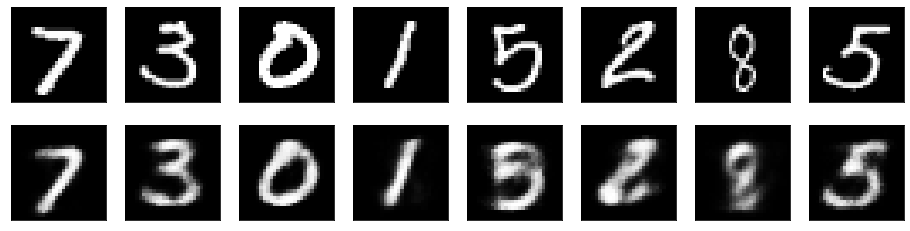

In [34]:
n = 8  # How many digits we will display
plt.figure(figsize=(16, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_digits[4000+i].reshape((28,28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Variational autoencoder (VAE)

In [41]:
# encoder

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
# Extract abstract features from the input
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# Map the extracted features to the latent space
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [25]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [42]:
# Sampling layer which takes sample from the latent space using Gaussian
# distribution with mean and variation z_mean and z_log_var.

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [43]:
# decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [24]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

In [44]:
# VAE subclassed model

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass of the encoder
            z_mean, z_log_var = self.encoder(data)
            # Forward pass of the sampler
            z = self.sampler(z_mean, z_log_var)
            # Forward pass of the decoder
            reconstruction = decoder(z)
            # Reconstruction loss compares the original image and its reconstructions
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL loss pushes the distribution towards a normal dist. near the origin
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Apply gradient descent
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

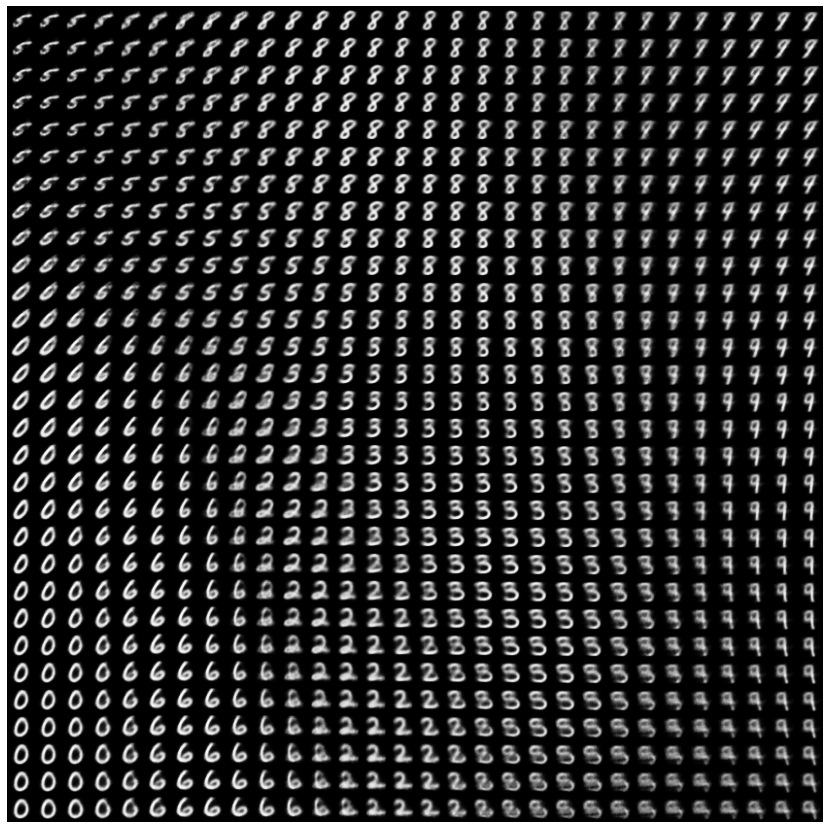

In [47]:
# Generate new images

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

## Generative adversarial networks (GAN)

Generative adversarial networks are similar in spirit to unsurpervised models. They consist of a "generator" similar to the decoder in VAEs which generates a sample from a random vector in the latent space, and the "adversary". The adversary takes samples as an input and determines whether the sample is real or fake/generated. During training, the generator constantly tries to fool the adversary while adversary tries to catch the fakes generator by the generator.

In [53]:
# discriminator or adversary model

discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [54]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dropout_1 (Dropout)         (None, 3136)              0         
                                                                 
 dense_13 (Dense)            (None, 1)               

In [55]:
# generator, similar to the decoder in VAEs

latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 64),
        layers.Reshape((7, 7, 64)),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [56]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 3136)              404544    
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 32)        0 

In [57]:
# GAN model class

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        # The model simultaneously optimizes the generator and the discriminator.
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        # Generate random latent vectors used by the generator.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Generator feedforward
        generated_images = self.generator(random_latent_vectors)
        # Mix the real and fake images.
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Introduce randomness which helps with training
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            # Discriminator feedforward
            predictions = self.discriminator(combined_images)
            # Compute loss function with true labels.
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Update discriminator weights.
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        
        # Pretend that the data generated below is real.
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            # Compute loss function with misleading labels.
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # Update generator weights.
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [51]:
# Callback to save a few images after each epoch.
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [59]:
epochs = 4

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(mnist_digits, epochs=epochs, 
        callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/4
2188/2188 [==============================] - 35s 15ms/step - d_loss: 0.6524 - g_loss: 0.8338
Epoch 2/4
2188/2188 [==============================] - 35s 16ms/step - d_loss: 0.6273 - g_loss: 0.8801
Epoch 3/4
2188/2188 [==============================] - 32s 15ms/step - d_loss: 0.5738 - g_loss: 0.9643
Epoch 4/4
2188/2188 [==============================] - 32s 15ms/step - d_loss: 0.5336 - g_loss: 1.0747


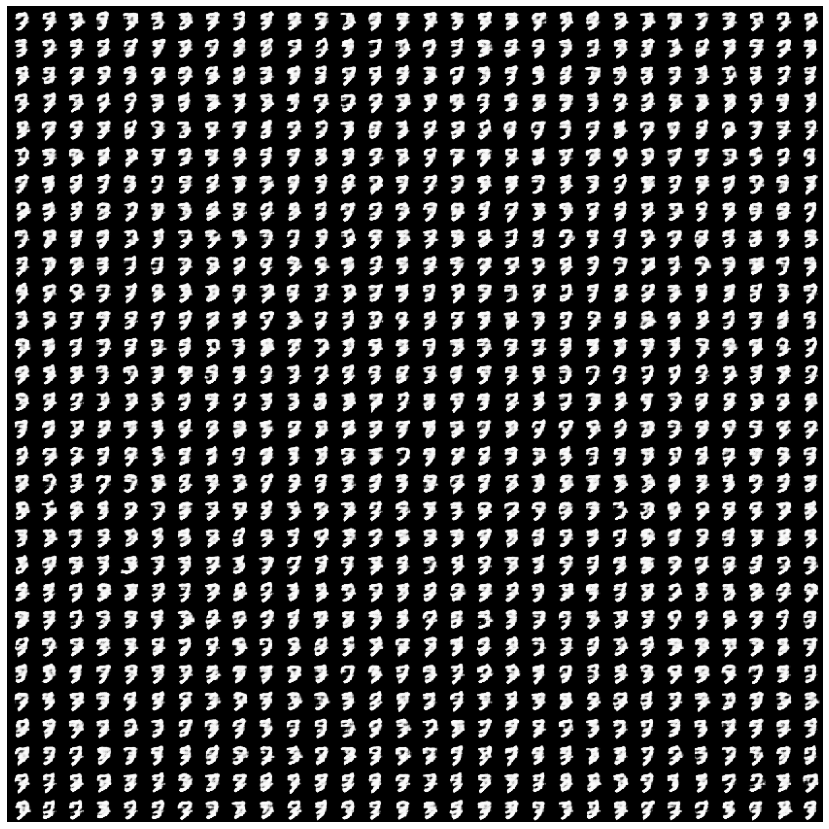

In [66]:
# Generate new images

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.random.rand(1,128)
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")